In [1]:
using Revise
using DiffusionModels

In [2]:
using Flux3D # Needs to bump dependency versions
using Makie
using GLMakie
GLMakie.activate!(inline=true)

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt /home/sam/.julia/packages/Flux/r3RWW/ext/FluxCUDAExt/FluxCUDAExt.jl:42


In [3]:
using DifferentialEquations

In [4]:
m = load_trimesh("teapot.obj")
p = PointCloud(m)
p.points = (p.points .+ minimum(p.points)) ./ (maximum(p.points) - minimum(p.points))

3×1000×1 Array{Float32, 3}:
[:, :, 1] =
 -0.187654  -0.761113  -0.495578  …  -0.5352    -0.746944  -0.655635
 -0.395989  -0.218565  -0.113526     -0.467532  -0.412846  -0.297757
 -0.513915  -0.499076  -0.716044     -0.637439  -0.479499  -0.219951

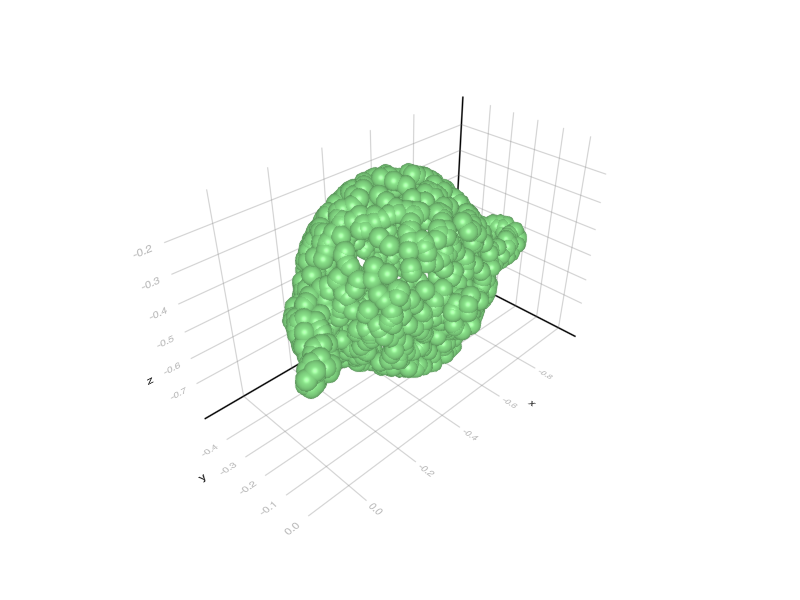

In [5]:
visualize(p, markersize=0.03)

In [6]:
# TODO: Noise schedule params need adjusting for this type of data
noise_schedule = CosineSchedule()
gaussian_diffusion = VPDiffusion(noise_schedule)
jump_schedule = ConstantJumpSchedule(max_dim=1000)
diffusion = DimensionalJumpDiffusion(
    gaussian_diffusion,
    jump_schedule,
    2,
)

DimensionalJumpDiffusion{VPDiffusion{Nothing}, Nothing}(VPDiffusion{Nothing}(CosineSchedule(0.0, 1.0, 1.0, 1.0e-9), nothing), ConstantJumpSchedule(1000, 1, 0.7), 2, nothing)

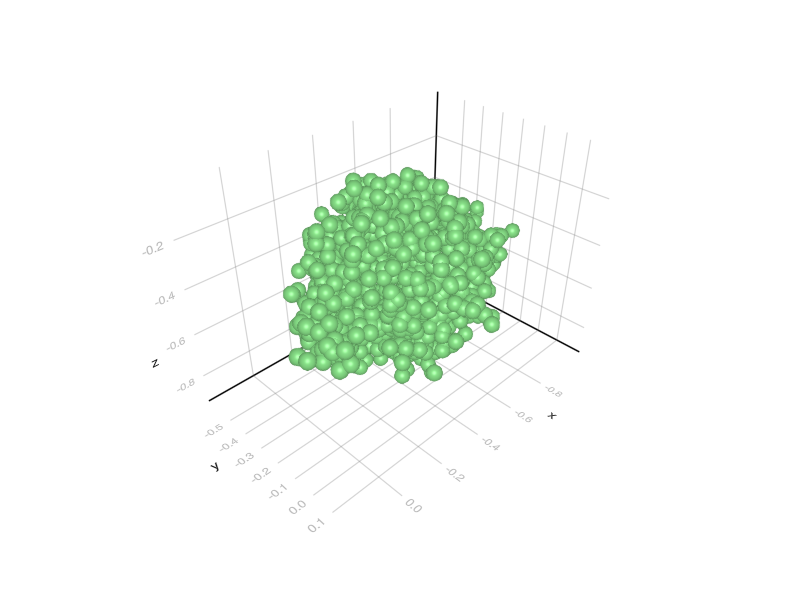

In [7]:
x_t = marginal(diffusion, p.points, 0.03)
# TODO: Need to change Gaussian diffusion to allow different number of dims
visualize(PointCloud(x_t[:,:,:,1]), markersize=0.03)

In [68]:
noise_schedule = CosineSchedule()
gaussian_diffusion = VPDiffusion(noise_schedule)
jump_schedule = ConstantJumpSchedule(max_dim=1000)
diffusion = DimensionalJumpDiffusion(
    gaussian_diffusion,
    jump_schedule,
    2,
)
prob = get_forward_diffeq(diffusion, p.points, (0.0,0.7))
sol = solve(prob, EM(); dt=0.1, save_everystep=false)
x_t = sol.u[end]
# visualize(PointCloud(reshape(x_t,1,:,1)), markersize=0.03)

3×1000×1 Array{Union{Missing, Float32}, 3}:
[:, :, 1] =
 missing  -1.95512  missing  missing  …  missing  missing  missing  missing
 missing  -1.35321  missing  missing     missing  missing  missing  missing
 missing   1.28951  missing  missing     missing  missing  missing  missing

In [66]:
count(ismissing, x_t[1,:,:])

734

In [64]:
length(sol.u) # WTF

1424

In [69]:
sol

retcode: Success
Interpolation: 1st order linear
t: 1358-element Vector{Float64}:
 0.0
 3.423103404039203e-5
 3.423103404039203e-5
 0.002234943692047371
 0.002234943692047371
 0.002907507738468891
 0.002907507738468891
 0.0029226136029391198
 0.0029226136029391198
 0.003335455807142365
 ⋮
 0.6940397243239923
 0.6940397243239923
 0.6942830172740659
 0.6942830172740659
 0.6974932439969211
 0.6974932439969211
 0.6993183977563118
 0.6993183977563118
 0.7
u: 1358-element Vector{Array{Union{Missing, Float32}, 3}}:
 [-0.1876536f0 -0.76111335f0 … -0.74694365f0 -0.6556347f0; -0.3959894f0 -0.21856453f0 … -0.41284564f0 -0.2977567f0; -0.51391506f0 -0.4990759f0 … -0.4794986f0 -0.21995129f0;;;]
 [-0.1876536f0 -0.76111335f0 … -0.74694365f0 -0.6556347f0; -0.3959894f0 -0.21856453f0 … -0.41284564f0 -0.2977567f0; -0.51391506f0 -0.4990759f0 … -0.4794986f0 -0.21995129f0;;;]
 [-0.1876536f0 -0.76111335f0 … -0.74694365f0 -0.6556347f0; -0.3959894f0 -0.21856453f0 … -0.41284564f0 -0.2977567f0; -0.51391506f0 -0.4

In [43]:
prob = get_forward_sde(gaussian_diffusion, x, tspan)
integrator = init(prob, EM(), dt=1e-3, )

ErrorException: type JumpProblem has no field u0

In [60]:
function test(x::AbstractArray)
    convert(AbstractArray{Union{Missing, eltype(x)}}, x)
end
test(zeros(2,2,2))

2×2×2 Array{Union{Missing, Float64}, 3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

[:, :, 2] =
 0.0  0.0
 0.0  0.0

In [7]:
drift, diffusion = get_drift_diffusion(gaussian_diffusion)